### Localization of multiple rectangles
Localization of multiple rectangles in a given image

The notebook program is modified based on object detection with neural networks — a simple tutorial using keras by Johannes Rieke.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

### Create images with random rectangles and bounding boxes. 

In [3]:
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
#     for i_object in range(num_objects):
#         width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
#         x = np.random.randint(0, img_size - width)
#         y = np.random.randint(0, img_size - height)
#         imgs[i_img, x:x+width, y:y+height] = 1.
#         bboxes[i_img, i_object] = [x, y, width, height]
        
        
#     Prevent overlap between rectangles.
#     Makes results (i.e. mean IOU) slightly worse; probably because the shapes are smaller 
#     (i.e. they are harder to recognize and capture within a bbox) 
#     and further apart (i.e. the algorithm can't set all bboxes to the same location to get a good IOU).    
    i_object = 0
    while i_object < num_objects:
        width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        overlap = False        
#         print 'Creating object', i_object, '- checking', len(bboxes[i_img, :i_object]), 'bboxes for overlap',
        for bbox in bboxes[i_img, :i_object]:  # TODO: Check if this includes all bboxes.
            overlap = bool(IOU(bbox, [x-1, y-1, width+2, height+2]))  # at least one free field between objects
            if overlap: 
#                 print '--> Found overlap'
                break
        if not overlap:
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            i_object += 1
#             print '--> Found no overlap'
#     print
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 3, 4))

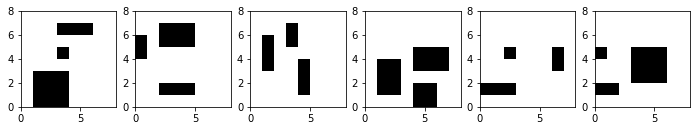

In [4]:
plt.figure(figsize=(12, 3))
for i in range(1, 7):
    plt.subplot(1, 6, i)
    plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
plt.show()
# for bbox in bboxes[i]:
#     plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

### Model Input and Output
Input: normalized image
Output: bounding box (bx1, by1, bw1, bh1, bx2, by2, bw2, bh2, bx3, by3, bw3, bh3)

In [5]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), -7.194245199571014e-18, 1.0000000000000002)

In [6]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape

(50000, 12)

### Split training and test.

In [7]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

### Build the model.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.5), 
        Dense(256),
        Activation('relu'),
        Dropout(0.5),
        Dense(y.shape[-1])
    ])
model.compile(Adam(0.0001, beta_1=0.5), 'mse')

In [9]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

### Train with flipping
Need to find the best match

In [10]:
num_epochs = 20
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)

        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = distance(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with minimum mse and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 10000000#-1  # set mse of assigned bboxes to a large number, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        # Write flipped bboxes to training data.
        flipped_train_y[sample] = exp_bboxes[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print()

Epoch 0
Train on 40000 samples, validate on 10000 samples
40000/40000 - 3s - loss: 0.1542 - val_loss: 0.0563
Flipped 66.1375 % of all elements
Mean IOU: 0.02811203080521649
Mean dist: 0.36940507114542614
Mean mse: 0.05557765065028564

Epoch 1
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0478 - val_loss: 0.0438
Flipped 50.93000000000001 % of all elements
Mean IOU: 0.043348286627813426
Mean dist: 0.31960681131713525
Mean mse: 0.040170613251413634

Epoch 2
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0336 - val_loss: 0.0401
Flipped 18.53166666666667 % of all elements
Mean IOU: 0.08419133583527497
Mean dist: 0.26123713838218493
Mean mse: 0.028974234492429064

Epoch 3
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0262 - val_loss: 0.0398
Flipped 9.155000000000001 % of all elements
Mean IOU: 0.12374700549424598
Mean dist: 0.2228744411297363
Mean mse: 0.022470964791748683

Epoch 4
Train on 40000 samp

### Results

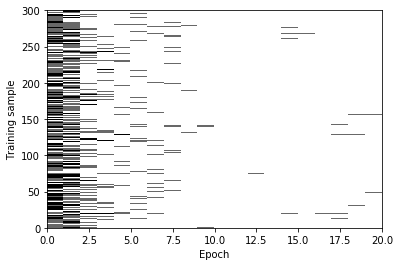

In [11]:
# Show flippings for a few training samples.
plt.pcolor(flipped[:300], cmap='Greys', vmax=1.)
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.show()

(0, 1)

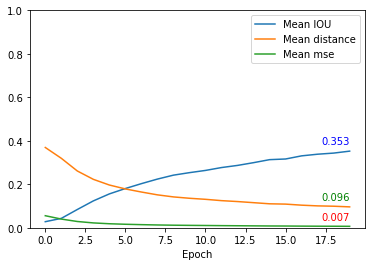

In [12]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)

In [13]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 3, 4)

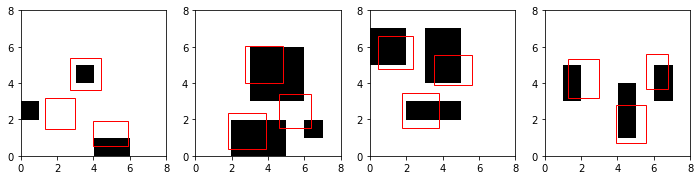

In [14]:
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))